# LLM - Detect AI Generated Text
## Import

In [100]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.corpus import stopwords
from gensim.corpora import Dictionary
from gensim.models import word2vec
from gensim.models import doc2vec
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import resample
from sklearn.metrics import roc_curve
from sklearn.metrics import auc


In [2]:
initial_dataset = pd.read_csv("../data/train_essays.csv")
prompts_dataset = pd.read_csv("../data/train_prompts.csv")

## Data analisis

In [3]:
initial_dataset

id  prompt_id                                               text  \
0     0059830c          0  Cars. Cars have been around since they became ...   
1     005db917          0  Transportation is a large necessity in most co...   
2     008f63e3          0  "America's love affair with it's vehicles seem...   
3     00940276          0  How often do you ride in a car? Do you drive a...   
4     00c39458          0  Cars are a wonderful thing. They are perhaps o...   
...        ...        ...                                                ...   
1373  fe6ff9a5          1  There has been a fuss about the Elector Colleg...   
1374  ff669174          0  Limiting car usage has many advantages. Such a...   
1375  ffa247e0          0  There's a new trend that has been developing f...   
1376  ffc237e9          0  As we all know cars are a big part of our soci...   
1377  ffe1ca0d          0  Cars have been around since the 1800's and hav...   

      generated  
0             0  
1             0  
2             0  
3             0  
4             0  
...         ...  
1373          0  
1374          0  
1375          0  
1376          0  
1377          0  

[1378 rows x 4 columns]

In [4]:
initial_dataset.dtypes

id           object
prompt_id     int64
text         object
generated     int64
dtype: object

In [5]:
initial_dataset.shape

(1378, 4)

In [6]:
initial_dataset.describe()

prompt_id    generated
count  1378.000000  1378.000000
mean      0.486212     0.002177
std       0.499991     0.046625
min       0.000000     0.000000
25%       0.000000     0.000000
50%       0.000000     0.000000
75%       1.000000     0.000000
max       1.000000     1.000000

`generated` - Whether the essay was written by a student (0) or generated by an LLM (1). This field is the target and is not present in test_essays.csv.

In [7]:
initial_dataset.value_counts("generated")

generated
0    1375
1       3
Name: count, dtype: int64

In [8]:
generated = initial_dataset.value_counts("generated")
generated

generated
0    1375
1       3
Name: count, dtype: int64

In [9]:
generated = generated.apply(lambda x : x/initial_dataset.shape[0])
generated

generated
0    0.997823
1    0.002177
Name: count, dtype: float64

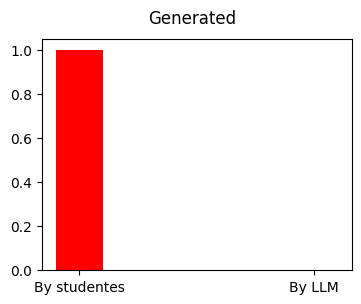

In [10]:
fig, ax = pt.subplots(figsize=(4,3))
fig.suptitle("Generated")
ax.bar(
    x=["By studentes","By LLM"],
    height=generated,
    width=0.2,
    color=["red","green"],
    align="center")
pt.show()

In [11]:
prompts_dataset

prompt_id                       prompt_name  \
0          0                   Car-free cities   
1          1  Does the electoral college work?   

                                        instructions  \
0  Write an explanatory essay to inform fellow ci...   
1  Write a letter to your state senator in which ...   

                                         source_text  
0  # In German Suburb, Life Goes On Without Cars ...  
1  # What Is the Electoral College? by the Office...

In [12]:
prompts = initial_dataset.value_counts("prompt_id")
prompts

prompt_id
0    708
1    670
Name: count, dtype: int64

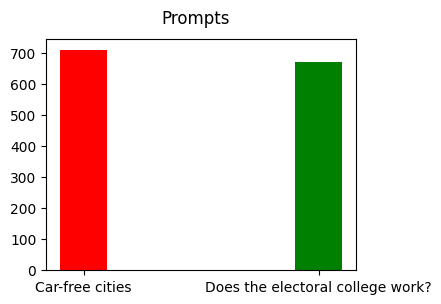

In [13]:
fig, ax = pt.subplots(figsize=(4,3))
fig.suptitle("Prompts")
ax.bar(
    x=["Car-free cities","Does the electoral college work?"],
    height=prompts,
    width=0.2,
    color=["red","green"],
    align="center")
pt.show()

## Handle imbalanced Data

> Because the class distribution is not balanced, most machine learning algorithms will perform
poorly and require modification to avoid simply predicting the majority class in all cases.
Additionally, metrics like classification accuracy lose their meaning and alternate methods for
evaluating predictions on imbalanced examples are required, like ROC area under curve. This is
the foundational challenge of imbalanced classification.
>
> - Jason Brownlee, *Imbalanced Classification with Python* (2020)

> If we think about feature space spatially, we might like all examples in one class to be located on one part
of the space, and those from the other class to appear in another part of the space. [...]
>This is rarely the case, and it is more likely that each class has multiple **concepts** resulting in multiple different groups or clusters of examples in feature space.
>
> - Jason Brownlee, *Imbalanced Classification with Python* (2020)


### Metrics for Imbalanced Data

>Although widely used, classification accuracy is almost universally inappropriate for imbalanced classification. The reason is, a high accuracy (or low error) is achievable by a no skill model that only predicts the majority class. [...]
>
> - Jason Brownlee, *Imbalanced Classification with Python* (2020)

>There are two groups of metrics that may be useful for imbalanced classification because they focus on one class; they are sensitivity-specificity and precision-recall.
>
> - Jason Brownlee, *Imbalanced Classification with Python* (2020)

>One limitation of these metrics is that they assume that the class distribution observed in the training dataset will match the distribution in the test set and in real data when the model is used to make predictions. [...] Ranking metrics don’t make any assumptions about class distributions.
>
> - Jason Brownlee, *Imbalanced Classification with Python* (2020)

>The most commonly used ranking metric is the ROC Curve or ROC Analysis. ROC is an
acronym that means Receiver Operating Characteristic and summarizes a field of study for
analyzing binary classifiers based on their ability to discriminate classes.
>
> - Jason Brownlee, *Imbalanced Classification with Python* (2020)

>Although generally effective, the ROC Curve and ROC AUC can be optimistic under a severe class imbalance, especially when the number of examples in the minority class is small.
An alternative to the ROC Curve is the precision-recall curve that can be used in a similar way, although focuses on the performance of the classifier on the minority class.
>
> - Jason Brownlee, *Imbalanced Classification with Python* (2020)


#### ROC AUC curve 

In [101]:
def ROCplot(model,x_val,y_val):
    #define metrics
    y_pred = model.predict(x_val).ravel()
    fpr, tpr, _ = roc_curve(y_val,  y_pred)
    auc = auc(fpr, tpr)
    #create ROC curve
    plt.plot(fpr,tpr,label="AUC="+str(auc))
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='AUC = 0.50')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

### Data Sampling for imbalanced data

> Sadly, k-fold cross-validation is not appropriate for evaluating imbalanced classifiers.
[...]
The reason is that the data is split into k-folds with a uniform probability distribution. This might work fine for data with a balanced class distribution, but when the distribution is severely skewed, it is likely that one or more folds will have few or no examples from the minority class.
>
> - Jason Brownlee, *Imbalanced Classification with Python* (2020)

> The solution is to not split the data randomly when using k-fold cross-validation or a train-test
split. [...] For example, we can use a version of k-fold cross-validation that preserves the imbalanced class distribution in each fold. It is called stratified k-fold cross-validation and will enforce the class distribution in each split of the data to match the distribution in the complete training dataset.
>
> - Jason Brownlee, *Imbalanced Classification with Python* (2020)

> Sampling is only performed on the training dataset, the dataset used by an algorithm to
learn a model. It is not performed on the holdout test or validation dataset.
>
> - Jason Brownlee, *Imbalanced Classification with Python* (2020)

- Stratified k-folding CrossValidation
- Random Downsampling
- Adding data as kind of Oversampling

#### Adding new Data

In [16]:
initial_dataset

id  prompt_id                                               text  \
0     0059830c          0  Cars. Cars have been around since they became ...   
1     005db917          0  Transportation is a large necessity in most co...   
2     008f63e3          0  "America's love affair with it's vehicles seem...   
3     00940276          0  How often do you ride in a car? Do you drive a...   
4     00c39458          0  Cars are a wonderful thing. They are perhaps o...   
...        ...        ...                                                ...   
1373  fe6ff9a5          1  There has been a fuss about the Elector Colleg...   
1374  ff669174          0  Limiting car usage has many advantages. Such a...   
1375  ffa247e0          0  There's a new trend that has been developing f...   
1376  ffc237e9          0  As we all know cars are a big part of our soci...   
1377  ffe1ca0d          0  Cars have been around since the 1800's and hav...   

      generated  
0             0  
1             0  
2             0  
3             0  
4             0  
...         ...  
1373          0  
1374          0  
1375          0  
1376          0  
1377          0  

[1378 rows x 4 columns]

In [17]:
1375/3
1375/13

105.76923076923077

Describing the imbalance of this dataset in terms of ration is 1:500. The dataset presents sever imbalance. By adding new data to the training set with text generated by ChatGPT 3, i desire to make it become near (1:100). To achieve this i need to add **10** generated text to the dataset.

This will modify the true distribution from the real dataset, but only 3 element in the minority class is not enough to apply stratified 10-fold cross validation.

In [18]:
# Adding data code.
new_data = pd.read_csv("../data/new_essays.csv")
new_data

id  prompt_id                                               text  generated
0   1          0  The Advantages of Limiting Car Usage in Suburb...          1
1   2          0  Paris' Driving Ban: A Temporary Solution to En...          1
2   3          0  Bogota's Car-Free Day: A Model for Sustainable...          1
3   4          0  Shifting Trends: The Decline of Car Culture in...          1
4   5          0  The End of Car Culture and the Rise of Sustain...          1
5   6          1  Dear Senator Thompson,  I am writing to expres...          1
6   7          1  Dear Senator Carter,  I am writing to express ...          1
7   8          1  Dear Senator Thompson,  I am writing to expres...          1
8   9          1  Dear Senator Johnson,  I am writing to draw yo...          1
9  10          1  Dear Senator Williams, I am writing to discuss...          1

In [19]:
target_data = pd.concat([initial_dataset,new_data],ignore_index=True)
target_data

id  prompt_id                                               text  \
0     0059830c          0  Cars. Cars have been around since they became ...   
1     005db917          0  Transportation is a large necessity in most co...   
2     008f63e3          0  "America's love affair with it's vehicles seem...   
3     00940276          0  How often do you ride in a car? Do you drive a...   
4     00c39458          0  Cars are a wonderful thing. They are perhaps o...   
...        ...        ...                                                ...   
1383         6          1  Dear Senator Thompson,  I am writing to expres...   
1384         7          1  Dear Senator Carter,  I am writing to express ...   
1385         8          1  Dear Senator Thompson,  I am writing to expres...   
1386         9          1  Dear Senator Johnson,  I am writing to draw yo...   
1387        10          1  Dear Senator Williams, I am writing to discuss...   

      generated  
0             0  
1             0  
2             0  
3             0  
4             0  
...         ...  
1383          1  
1384          1  
1385          1  
1386          1  
1387          1  

[1388 rows x 4 columns]

## Data Feature Engineering

##### Tokenizar

##### Words Tokenizing

In [20]:
tokenized_dataset = target_data.copy()
tokenized_dataset["text"] = target_data["text"].apply(lambda x : word_tokenize(text=x))
tokenized_dataset

id  prompt_id                                               text  \
0     0059830c          0  [Cars, ., Cars, have, been, around, since, the...   
1     005db917          0  [Transportation, is, a, large, necessity, in, ...   
2     008f63e3          0  [``, America, 's, love, affair, with, it, 's, ...   
3     00940276          0  [How, often, do, you, ride, in, a, car, ?, Do,...   
4     00c39458          0  [Cars, are, a, wonderful, thing, ., They, are,...   
...        ...        ...                                                ...   
1383         6          1  [Dear, Senator, Thompson, ,, I, am, writing, t...   
1384         7          1  [Dear, Senator, Carter, ,, I, am, writing, to,...   
1385         8          1  [Dear, Senator, Thompson, ,, I, am, writing, t...   
1386         9          1  [Dear, Senator, Johnson, ,, I, am, writing, to...   
1387        10          1  [Dear, Senator, Williams, ,, I, am, writing, t...   

      generated  
0             0  
1             0  
2             0  
3             0  
4             0  
...         ...  
1383          1  
1384          1  
1385          1  
1386          1  
1387          1  

[1388 rows x 4 columns]

##### Sentence Tokenizing

In [21]:
sentence_dataset = target_data.copy()
sentence_dataset["text"] = target_data["text"].apply(lambda x: sent_tokenize(x))
sentence_dataset

id  prompt_id                                               text  \
0     0059830c          0  [Cars., Cars have been around since they becam...   
1     005db917          0  [Transportation is a large necessity in most c...   
2     008f63e3          0  ["America's love affair with it's vehicles see...   
3     00940276          0  [How often do you ride in a car?, Do you drive...   
4     00c39458          0  [Cars are a wonderful thing., They are perhaps...   
...        ...        ...                                                ...   
1383         6          1  [Dear Senator Thompson,  I am writing to expre...   
1384         7          1  [Dear Senator Carter,  I am writing to express...   
1385         8          1  [Dear Senator Thompson,  I am writing to expre...   
1386         9          1  [Dear Senator Johnson,  I am writing to draw y...   
1387        10          1  [Dear Senator Williams, I am writing to discus...   

      generated  
0             0  
1             0  
2             0  
3             0  
4             0  
...         ...  
1383          1  
1384          1  
1385          1  
1386          1  
1387          1  

[1388 rows x 4 columns]

#### Eliminación de stopwords y de simbolos de puntuación.

In [22]:
cleaned_dataset = tokenized_dataset.copy()
def eraseStopWordsAndPunctuation(tokenList):
    tokens = [token.lower() for token in tokenList if token.isalpha()]  # Pasar a minúsculas y eliminar números
    tokens = [word for word in tokens if word not in stopwords.words('english')]  # Eliminar stopwords
    return tokens
cleaned_dataset["text"] = tokenized_dataset["text"].apply(lambda l : eraseStopWordsAndPunctuation(l))      

### Text to bag of words

##### Creating Dictionaries

In [23]:
tokenized_dictionary = Dictionary(tokenized_dataset["text"])
tokenized_dictionary.token2id

{"''": 0,
 "'s": 1,
 ',': 2,
 '.': 3,
 '...': 4,
 '12': 5,
 '1900s': 6,
 '22euro': 7,
 '31': 8,
 '50': 9,
 '7': 10,
 'America': 11,
 'Andrew': 12,
 'Article': 13,
 'Bogota': 14,
 'But': 15,
 'Carfree': 16,
 'Cars': 17,
 'Chicago': 18,
 'Columbia': 19,
 'Columbians': 20,
 'Day': 21,
 'Duffer': 22,
 'Elizabeth': 23,
 'Europe': 24,
 'Experts': 25,
 'Ford': 26,
 'German': 27,
 'Goes': 28,
 'Having': 29,
 'Henry': 30,
 'In': 31,
 'It': 32,
 'Life': 33,
 'Likewise': 34,
 'Limiting': 35,
 'ModelT': 36,
 'Monday': 37,
 'On': 38,
 'Paris': 39,
 'Passenger': 40,
 'People': 41,
 'Robert': 42,
 'Rosenthal': 43,
 'Selsky': 44,
 'Shanghai': 45,
 'So': 46,
 'States': 47,
 'Suburb': 48,
 'The': 49,
 'This': 50,
 'To': 51,
 'United': 52,
 'Without': 53,
 '``': 54,
 'a': 55,
 'after': 56,
 'air': 57,
 'all': 58,
 'allows': 59,
 'aloud': 60,
 'also': 61,
 'an': 62,
 'and': 63,
 'applied': 64,
 'are': 65,
 'areas': 66,
 'around': 67,
 'article': 68,
 'at': 69,
 'automobiles': 70,
 'bad': 71,
 'ban': 72,
 

In [24]:
cleaned_dictionary = Dictionary(cleaned_dataset["text"])
cleaned_dictionary.token2id

{'air': 0,
 'allows': 1,
 'aloud': 2,
 'also': 3,
 'america': 4,
 'andrew': 5,
 'applied': 6,
 'areas': 7,
 'around': 8,
 'article': 9,
 'automobiles': 10,
 'bad': 11,
 'ban': 12,
 'banned': 13,
 'bans': 14,
 'became': 15,
 'big': 16,
 'bike': 17,
 'biked': 18,
 'bogota': 19,
 'broad': 20,
 'built': 21,
 'bus': 22,
 'buses': 23,
 'bustled': 24,
 'capital': 25,
 'car': 26,
 'carfree': 27,
 'carintensive': 28,
 'cars': 29,
 'cause': 30,
 'centers': 31,
 'chicago': 32,
 'cities': 33,
 'city': 34,
 'class': 35,
 'clear': 36,
 'columbia': 37,
 'columbians': 38,
 'conclusion': 39,
 'countries': 40,
 'country': 41,
 'created': 42,
 'cropped': 43,
 'current': 44,
 'cut': 45,
 'cutting': 46,
 'day': 47,
 'days': 48,
 'devoid': 49,
 'districts': 50,
 'dramatically': 51,
 'driving': 52,
 'due': 53,
 'duffer': 54,
 'eerily': 55,
 'efforts': 56,
 'either': 57,
 'elizabeth': 58,
 'emissions': 59,
 'enforced': 60,
 'entire': 61,
 'environment': 62,
 'europe': 63,
 'evennumbered': 64,
 'every': 65,
 '

In [25]:
cleaned_dictionary.filter_extremes(no_below=5, no_above=0.5)

In [26]:
# Crear la bolsa de palabras
bow = [tokenized_dictionary.doc2bow(text) for text in tokenized_dataset["text"]]
cleaned_bow = [cleaned_dictionary.doc2bow(text) for text in cleaned_dataset["text"]]
bow

[[(0, 3),
  (1, 1),
  (2, 40),
  (3, 23),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 7),
  (18, 1),
  (19, 2),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 1),
  (30, 1),
  (31, 3),
  (32, 2),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 3),
  (40, 1),
  (41, 1),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 1),
  (46, 1),
  (47, 1),
  (48, 1),
  (49, 2),
  (50, 1),
  (51, 2),
  (52, 1),
  (53, 2),
  (54, 3),
  (55, 15),
  (56, 1),
  (57, 2),
  (58, 4),
  (59, 1),
  (60, 2),
  (61, 2),
  (62, 1),
  (63, 11),
  (64, 1),
  (65, 5),
  (66, 1),
  (67, 3),
  (68, 3),
  (69, 1),
  (70, 1),
  (71, 1),
  (72, 1),
  (73, 1),
  (74, 1),
  (75, 7),
  (76, 1),
  (77, 5),
  (78, 4),
  (79, 2),
  (80, 1),
  (81, 1),
  (82, 1),
  (83, 1),
  (84, 1),
  (85, 1),
  (86, 1),
  (87, 5),
  (88, 2),
  (89, 2),
  (90, 2),
  (91

### Text to word embeddings

In [27]:
# Utilizar word2vec para crear los ebeddings.
bow_model = word2vec.Word2Vec(tokenized_dataset["text"],vector_size=100)
bow_model.train(tokenized_dataset["text"],total_examples=tokenized_dataset.shape[0],epochs=10)

(5927687, 8594750)

In [28]:
bow_model.wv["Cars"]

array([ 1.4468548 ,  1.6088896 ,  1.9940631 , -2.4641378 ,  1.3424274 ,
       -2.1068487 , -1.7277567 ,  0.76071393,  0.5735658 , -2.571772  ,
       -2.3055637 ,  1.4969299 ,  1.2822319 ,  1.312677  ,  0.7838611 ,
        0.14159244, -0.20533344, -2.491036  ,  3.2023168 , -0.29886416,
       -0.8988662 ,  3.7468624 , -0.690414  ,  0.16365041,  0.33517826,
        0.74720544, -0.92774135, -0.25600773,  4.3572345 , -1.5135546 ,
        1.6144602 , -0.18129966, -1.0803692 , -0.30485085, -0.51219237,
       -0.36944827, -0.98991466, -0.6182019 , -1.4542996 ,  0.00768285,
       -0.9923412 ,  0.64321953,  2.6969469 , -1.4361967 ,  1.2097036 ,
       -2.730771  , -0.29108068, -1.0277898 , -1.9456942 ,  1.1639237 ,
        0.8523378 ,  1.155765  , -1.0850666 ,  1.828375  , -1.4865134 ,
       -1.8634526 ,  1.2280779 ,  0.97802967,  0.5646418 , -2.1768723 ,
       -0.6752274 ,  0.55737907, -0.35317945,  0.52891415,  1.0230477 ,
       -0.38482845,  2.0722206 , -2.9479284 ,  1.3845342 ,  1.59

#### Text to document embeddings

In [29]:
docs_dataset = tokenized_dataset.copy()
docs_dataset["text"] = [doc2vec.TaggedDocument(doc,[i]) for i,doc in enumerate(tokenized_dataset["text"])]
docs_dataset["text"]

0       ([Cars, ., Cars, have, been, around, since, th...
1       ([Transportation, is, a, large, necessity, in,...
2       ([``, America, 's, love, affair, with, it, 's,...
3       ([How, often, do, you, ride, in, a, car, ?, Do...
4       ([Cars, are, a, wonderful, thing, ., They, are...
                              ...                        
1383    ([Dear, Senator, Thompson, ,, I, am, writing, ...
1384    ([Dear, Senator, Carter, ,, I, am, writing, to...
1385    ([Dear, Senator, Thompson, ,, I, am, writing, ...
1386    ([Dear, Senator, Johnson, ,, I, am, writing, t...
1387    ([Dear, Senator, Williams, ,, I, am, writing, ...
Name: text, Length: 1388, dtype: object

In [30]:
doc_model = doc2vec.Doc2Vec(documents=docs_dataset["text"],vector_size=100)
doc_model.train(docs_dataset["text"],total_examples=tokenized_dataset.shape[0],epochs=10)

In [31]:
doc_model.dv[0]

array([-1.5108225 ,  0.52759254, -0.39156756,  0.54303813, -0.25780693,
       -1.0956194 , -0.68803895,  0.5525954 , -0.03337243, -0.27666897,
       -0.6290812 , -0.10311272, -0.663395  ,  0.80667806, -0.3972022 ,
       -0.71150786, -0.6674584 , -0.18976253, -0.15154383, -1.7097573 ,
       -0.76826155,  0.24071342, -0.29465646,  0.451054  ,  0.1826905 ,
        1.744296  , -0.7299643 ,  0.10102277,  0.922397  , -0.96988153,
        1.4589853 ,  1.0820067 ,  0.24901654,  0.60354257, -0.07690948,
       -0.19946165,  0.1417933 , -0.77939326, -0.38015324, -0.79931366,
        1.281702  ,  0.45102307,  0.13215819, -1.6297272 , -0.79918563,
       -0.8684869 ,  0.3128762 ,  0.0624882 ,  0.51225775, -0.355532  ,
       -0.4564691 , -0.03836151, -0.03373885,  0.23670575,  0.41943204,
        1.1698941 , -0.016342  , -0.03365167,  0.84542274, -0.30853367,
       -0.32561958,  0.6519817 ,  0.4989228 , -0.03335217, -0.1291962 ,
       -1.1227905 ,  0.74983007, -0.2977612 , -0.96662205,  0.26

In [52]:
arr = [doc_model.dv[docs_dataset["text"][index].tags] for index in range (0,docs_dataset.shape[0])]
embeddings_dataset = pd.DataFrame(np.reshape(arr,(1388, 100)))
embeddings_dataset

0         1         2         3         4         5         6   \
0    -1.510823  0.527593 -0.391568  0.543038 -0.257807 -1.095619 -0.688039   
1    -0.868957 -0.320128 -0.124018 -0.647562  1.066697  0.003709 -0.494840   
2    -1.174877 -0.162124  0.837011 -0.589101  0.972846 -0.438122 -0.261846   
3    -0.339296  0.319174 -0.562455 -1.808119  0.262719 -1.058542  0.415386   
4    -0.977686  0.253768  0.243498  0.691848  1.100971 -2.445900 -0.625094   
...        ...       ...       ...       ...       ...       ...       ...   
1383 -0.438469  0.136824 -0.681331  1.180853  1.114567  0.330710  0.485947   
1384 -0.405981  0.073973 -0.982371  1.296485  0.895061  0.293770  0.334527   
1385 -0.083557 -0.126636 -0.062972  0.961655  0.642889  0.089468  0.872111   
1386 -0.729393 -0.130108 -0.150950  1.137428  0.635303 -0.172319  0.592674   
1387 -0.967426  0.255533 -0.007404  1.383045  0.530507 -0.069571  0.283146   

            7         8         9   ...        90        91        92  \
0     0.552595 -0.033372 -0.276669  ...  0.397137  1.260202  0.609901   
1     0.500152  0.155427  0.847092  ... -0.069498 -0.660435  0.077824   
2     0.096832 -1.005364 -0.778611  ... -0.090941  1.870086 -0.257146   
3     0.851109 -0.295904 -0.624047  ... -0.394185  1.545319  0.821194   
4     0.850493 -0.674469 -1.436439  ... -1.012303  1.031600 -0.255132   
...        ...       ...       ...  ...       ...       ...       ...   
1383  0.244233 -0.413360 -0.013258  ... -0.113408  0.576085  0.746546   
1384  0.143230 -0.676622  0.211580  ... -0.173972  0.728993  0.360813   
1385  0.479118 -0.859082  0.367787  ... -0.217927  0.466888  0.399895   
1386  0.406948 -1.050308  0.194423  ... -0.088899  0.364537  0.436853   
1387  0.376160 -0.584272  0.112148  ...  0.157170  0.771822  0.229402   

            93        94        95        96        97        98        99  
0     0.270776  0.268696  0.978110  0.729362  0.432346  1.895268  0.911716  
1    -0.050313  0.089915  0.939129  0.039258 -0.210359  1.004433 -0.370160  
2    -0.587504 -0.572375  0.669869  0.204946  0.077233  0.412738  0.124962  
3     0.600906 -0.274229  0.487344  0.845245 -0.647711  0.626380 -0.840992  
4     0.067692 -0.436588 -0.425931  0.777718  0.071189  1.518585 -0.089573  
...        ...       ...       ...       ...       ...       ...       ...  
1383 -0.500098 -0.194502  1.196439  0.170107 -0.152328 -0.578429  0.286467  
1384 -0.150914 -0.089565  0.441933 -0.031979 -0.318564  0.499639 -0.504490  
1385 -0.484941 -0.724343  1.319585 -0.695676 -0.719789  0.118022 -0.407092  
1386 -0.239996 -0.239727 -0.116512 -0.211175 -0.400865 -0.330603  0.047176  
1387 -0.396659 -0.127405  0.977015 -0.199479 -0.401749 -0.005081  0.000449  

[1388 rows x 100 columns]

In [58]:
pre_processed_data = pd.concat([docs_dataset,embeddings_dataset],axis=1)
pre_processed_data

id  prompt_id                                               text  \
0     0059830c          0  ([Cars, ., Cars, have, been, around, since, th...   
1     005db917          0  ([Transportation, is, a, large, necessity, in,...   
2     008f63e3          0  ([``, America, 's, love, affair, with, it, 's,...   
3     00940276          0  ([How, often, do, you, ride, in, a, car, ?, Do...   
4     00c39458          0  ([Cars, are, a, wonderful, thing, ., They, are...   
...        ...        ...                                                ...   
1383         6          1  ([Dear, Senator, Thompson, ,, I, am, writing, ...   
1384         7          1  ([Dear, Senator, Carter, ,, I, am, writing, to...   
1385         8          1  ([Dear, Senator, Thompson, ,, I, am, writing, ...   
1386         9          1  ([Dear, Senator, Johnson, ,, I, am, writing, t...   
1387        10          1  ([Dear, Senator, Williams, ,, I, am, writing, ...   

      generated         0         1         2         3         4         5  \
0             0 -1.510823  0.527593 -0.391568  0.543038 -0.257807 -1.095619   
1             0 -0.868957 -0.320128 -0.124018 -0.647562  1.066697  0.003709   
2             0 -1.174877 -0.162124  0.837011 -0.589101  0.972846 -0.438122   
3             0 -0.339296  0.319174 -0.562455 -1.808119  0.262719 -1.058542   
4             0 -0.977686  0.253768  0.243498  0.691848  1.100971 -2.445900   
...         ...       ...       ...       ...       ...       ...       ...   
1383          1 -0.438469  0.136824 -0.681331  1.180853  1.114567  0.330710   
1384          1 -0.405981  0.073973 -0.982371  1.296485  0.895061  0.293770   
1385          1 -0.083557 -0.126636 -0.062972  0.961655  0.642889  0.089468   
1386          1 -0.729393 -0.130108 -0.150950  1.137428  0.635303 -0.172319   
1387          1 -0.967426  0.255533 -0.007404  1.383045  0.530507 -0.069571   

      ...        90        91        92        93        94        95  \
0     ...  0.397137  1.260202  0.609901  0.270776  0.268696  0.978110   
1     ... -0.069498 -0.660435  0.077824 -0.050313  0.089915  0.939129   
2     ... -0.090941  1.870086 -0.257146 -0.587504 -0.572375  0.669869   
3     ... -0.394185  1.545319  0.821194  0.600906 -0.274229  0.487344   
4     ... -1.012303  1.031600 -0.255132  0.067692 -0.436588 -0.425931   
...   ...       ...       ...       ...       ...       ...       ...   
1383  ... -0.113408  0.576085  0.746546 -0.500098 -0.194502  1.196439   
1384  ... -0.173972  0.728993  0.360813 -0.150914 -0.089565  0.441933   
1385  ... -0.217927  0.466888  0.399895 -0.484941 -0.724343  1.319585   
1386  ... -0.088899  0.364537  0.436853 -0.239996 -0.239727 -0.116512   
1387  ...  0.157170  0.771822  0.229402 -0.396659 -0.127405  0.977015   

            96        97        98        99  
0     0.729362  0.432346  1.895268  0.911716  
1     0.039258 -0.210359  1.004433 -0.370160  
2     0.204946  0.077233  0.412738  0.124962  
3     0.845245 -0.647711  0.626380 -0.840992  
4     0.777718  0.071189  1.518585 -0.089573  
...        ...       ...       ...       ...  
1383  0.170107 -0.152328 -0.578429  0.286467  
1384 -0.031979 -0.318564  0.499639 -0.504490  
1385 -0.695676 -0.719789  0.118022 -0.407092  
1386 -0.211175 -0.400865 -0.330603  0.047176  
1387 -0.199479 -0.401749 -0.005081  0.000449  

[1388 rows x 104 columns]

### Infered Features

In [62]:
#cantidad de palabra
#cantidad de oraciones
#cantidad de puntos
#cantidad de comas
#cantidad de apostrofes

658

In [63]:
pre_processed_data = pre_processed_data.drop("text",axis=1)

id  prompt_id  generated         0         1         2         3  \
0     0059830c          0          0 -1.510823  0.527593 -0.391568  0.543038   
1     005db917          0          0 -0.868957 -0.320128 -0.124018 -0.647562   
2     008f63e3          0          0 -1.174877 -0.162124  0.837011 -0.589101   
3     00940276          0          0 -0.339296  0.319174 -0.562455 -1.808119   
4     00c39458          0          0 -0.977686  0.253768  0.243498  0.691848   
...        ...        ...        ...       ...       ...       ...       ...   
1383         6          1          1 -0.438469  0.136824 -0.681331  1.180853   
1384         7          1          1 -0.405981  0.073973 -0.982371  1.296485   
1385         8          1          1 -0.083557 -0.126636 -0.062972  0.961655   
1386         9          1          1 -0.729393 -0.130108 -0.150950  1.137428   
1387        10          1          1 -0.967426  0.255533 -0.007404  1.383045   

             4         5         6  ...        90        91        92  \
0    -0.257807 -1.095619 -0.688039  ...  0.397137  1.260202  0.609901   
1     1.066697  0.003709 -0.494840  ... -0.069498 -0.660435  0.077824   
2     0.972846 -0.438122 -0.261846  ... -0.090941  1.870086 -0.257146   
3     0.262719 -1.058542  0.415386  ... -0.394185  1.545319  0.821194   
4     1.100971 -2.445900 -0.625094  ... -1.012303  1.031600 -0.255132   
...        ...       ...       ...  ...       ...       ...       ...   
1383  1.114567  0.330710  0.485947  ... -0.113408  0.576085  0.746546   
1384  0.895061  0.293770  0.334527  ... -0.173972  0.728993  0.360813   
1385  0.642889  0.089468  0.872111  ... -0.217927  0.466888  0.399895   
1386  0.635303 -0.172319  0.592674  ... -0.088899  0.364537  0.436853   
1387  0.530507 -0.069571  0.283146  ...  0.157170  0.771822  0.229402   

            93        94        95        96        97        98        99  
0     0.270776  0.268696  0.978110  0.729362  0.432346  1.895268  0.911716  
1    -0.050313  0.089915  0.939129  0.039258 -0.210359  1.004433 -0.370160  
2    -0.587504 -0.572375  0.669869  0.204946  0.077233  0.412738  0.124962  
3     0.600906 -0.274229  0.487344  0.845245 -0.647711  0.626380 -0.840992  
4     0.067692 -0.436588 -0.425931  0.777718  0.071189  1.518585 -0.089573  
...        ...       ...       ...       ...       ...       ...       ...  
1383 -0.500098 -0.194502  1.196439  0.170107 -0.152328 -0.578429  0.286467  
1384 -0.150914 -0.089565  0.441933 -0.031979 -0.318564  0.499639 -0.504490  
1385 -0.484941 -0.724343  1.319585 -0.695676 -0.719789  0.118022 -0.407092  
1386 -0.239996 -0.239727 -0.116512 -0.211175 -0.400865 -0.330603  0.047176  
1387 -0.396659 -0.127405  0.977015 -0.199479 -0.401749 -0.005081  0.000449  

[1388 rows x 103 columns]

## Model Training

In [89]:
def downsampling(X_train,y_train,rand_state,ratio):
    # Concatenate X_train and y_train for ease of downsampling
    train_data = pd.concat([X_train, y_train], axis=1)

    # Identify the class with the majority of instances
    majority_class = train_data[y_train.name].value_counts().idxmax()

    # Separate instances of each class
    majority_class_data = train_data[train_data[y_train.name] == majority_class]
    minority_class_data = train_data[train_data[y_train.name] != majority_class]
    
    
    currRatio = len(majority_class_data) / len(minority_class_data)
    if(currRatio<=ratio):
        raise ValueError(f"El ratio de entrada debe ser menor al ratio actual.r={currRatio}")
    

    # Downsample the majority class to match the number of instances in the minority class
    downsampled_majority_class_data = resample(
        majority_class_data,
        replace=False,
        n_samples=math.floor(ratio*len(minority_class_data)),
        random_state=rand_state
    )

    # Combine the downsampled majority class with the minority class
    downsampled_train_data = pd.concat([downsampled_majority_class_data, minority_class_data])

    # Shuffle the data to avoid any order-based patterns
    downsampled_train_data = downsampled_train_data.sample(frac=1, random_state=rand_state)

    # Separate X_train and y_train after downsampling
    X_train_downsampled = downsampled_train_data.drop(columns=[y_train.name])
    y_train_downsampled = downsampled_train_data[y_train.name]

    return X_train_downsampled, y_train_downsampled

In [75]:
NNmodel = keras.Dense();

NNmodel.compile(optimizer='sgd',
               loss=keras.losses.BinaryCrossentropy(),
               metrics=[keras.metrics.AUC()])
    

In [96]:
#NN training with 10-fold cross-validation stratified with random under-sampling technic for imbalanced data
rand_state=12
X = pre_processed_data.drop("generated",axis=1)
Y = pre_processed_data["generated"]
folds = StratifiedKFold(10,shuffle=True,random_state=rand_state)
for fold, (train_index, val_index) in enumerate(folds.split(X,Y)):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = Y.iloc[train_index], Y.iloc[val_index]

    X_train_dwns, y_train_dwns = downsampling(X_train,y_train,rand_state,ratio=50)
 
    #print(f"Fold {fold + 1}: Train {len(train_index)} samples, Validation {len(val_index)} samples")
    #print(f"TRAIN:({y_train[y_train==0].size}:{y_train[y_train==1].size})")
    #print(f"DOWNSAMPLED:({y_train_dwns[y_train_dwns==0].size}:{y_train_dwns[y_train_dwns==1].size})")
    #print(f"VAL:({y_val[y_val==0].size}:{y_val[y_val==1].size})")
 
    NNModel.fit(x_train,y_train,epoch=10)

    ROCplot(model,x_val,y_val)


Fold 1: Train 1249 samples, Validation 139 samples
TRAIN:(1237:12)
DOWNSAMPLED:(600:12)
VAL:(138:1)
trained
Fold 2: Train 1249 samples, Validation 139 samples
TRAIN:(1237:12)
DOWNSAMPLED:(600:12)
VAL:(138:1)
trained
Fold 3: Train 1249 samples, Validation 139 samples
TRAIN:(1237:12)
DOWNSAMPLED:(600:12)
VAL:(138:1)
trained
Fold 4: Train 1249 samples, Validation 139 samples
TRAIN:(1237:12)
DOWNSAMPLED:(600:12)
VAL:(138:1)
trained
Fold 5: Train 1249 samples, Validation 139 samples
TRAIN:(1237:12)
DOWNSAMPLED:(600:12)
VAL:(138:1)
trained
Fold 6: Train 1249 samples, Validation 139 samples
TRAIN:(1238:11)
DOWNSAMPLED:(550:11)
VAL:(137:2)
trained
Fold 7: Train 1249 samples, Validation 139 samples
TRAIN:(1238:11)
DOWNSAMPLED:(550:11)
VAL:(137:2)
trained
Fold 8: Train 1249 samples, Validation 139 samples
TRAIN:(1238:11)
DOWNSAMPLED:(550:11)
VAL:(137:2)
trained
Fold 9: Train 1250 samples, Validation 138 samples
TRAIN:(1238:12)
DOWNSAMPLED:(600:12)
VAL:(137:1)
trained
Fold 10: Train 1250 samples,

## Model test